This notebook provides an analysis of our data, as well as an analysis on our results.

Required files:
- `kaggle_train.csv`: you can obtain this file from the [SIIM-ISIC Melanoma Classification Challenge page on Kaggle](https://www.kaggle.com/competitions/siim-isic-melanoma-classification/data)
- `df_train.csv`: This file is the train file after the preprocessing. In order to create it, you'll need to run the `melanoma_classification.ipynb`.
- `cross_val_oof_predictions_auc.csv`: This file contains the cross validation results of the combination of the CNN and the XGBoost models. In order to create it, you'll need to run the `melanoma_classification.ipynb`.

# Imports

In [21]:
import os
import re
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_train_unprocessed = pd.read_csv("kaggle_train.csv") # the original train data from kaggle
df_train_preprocessed = pd.read_csv("df_train.csv") # the pre-processed data

# Explore the train features

## Explore features distribution

In [3]:
def plot_features_distribution(df: pd.DataFrame):
    numerical_cols = df.select_dtypes(include=['number']).columns
    cols_to_remove = {"is_ext", "fold", "image_size", "anomaly_score", "n_images", "target"}
    continuous_cols = {"image_size", "anomaly_score", "n_images"}
    numerical_cols = [col for col in numerical_cols if col not in cols_to_remove]

    plt.figure(figsize=(15, 15))
    num_plots = len(numerical_cols) + len(continuous_cols)
    for i, col in enumerate(numerical_cols + list(continuous_cols), 1):
        plt.subplot(num_plots // 3 + 1, 3, i)
        if col in continuous_cols:
            sns.kdeplot(df[col].dropna(), fill=True, color='blue', alpha=0.7)
            plt.title(f'Distribution of {col}')
            plt.ylabel('Density')
            if col in ["n_images", "image_size"]:
                plt.xlabel('Value - log scale')
            else:
                plt.xlabel('Value')

        else:
            plt.hist(df[col].dropna(), bins=30, alpha=0.7, color='blue')
            plt.title(col)

            if col in ["site_oral/genital", "site_palms/soles", "site_nan", "site_head/neck", ]:
                plt.yscale('log')
                plt.ylabel('Frequency - log scale')
            else:
                plt.ylabel('Frequency')
                plt.xlabel('Value')
    plt.suptitle("Feature distribution for the train dataframe", fontsize=18)
    plt.tight_layout()
    plt.show()

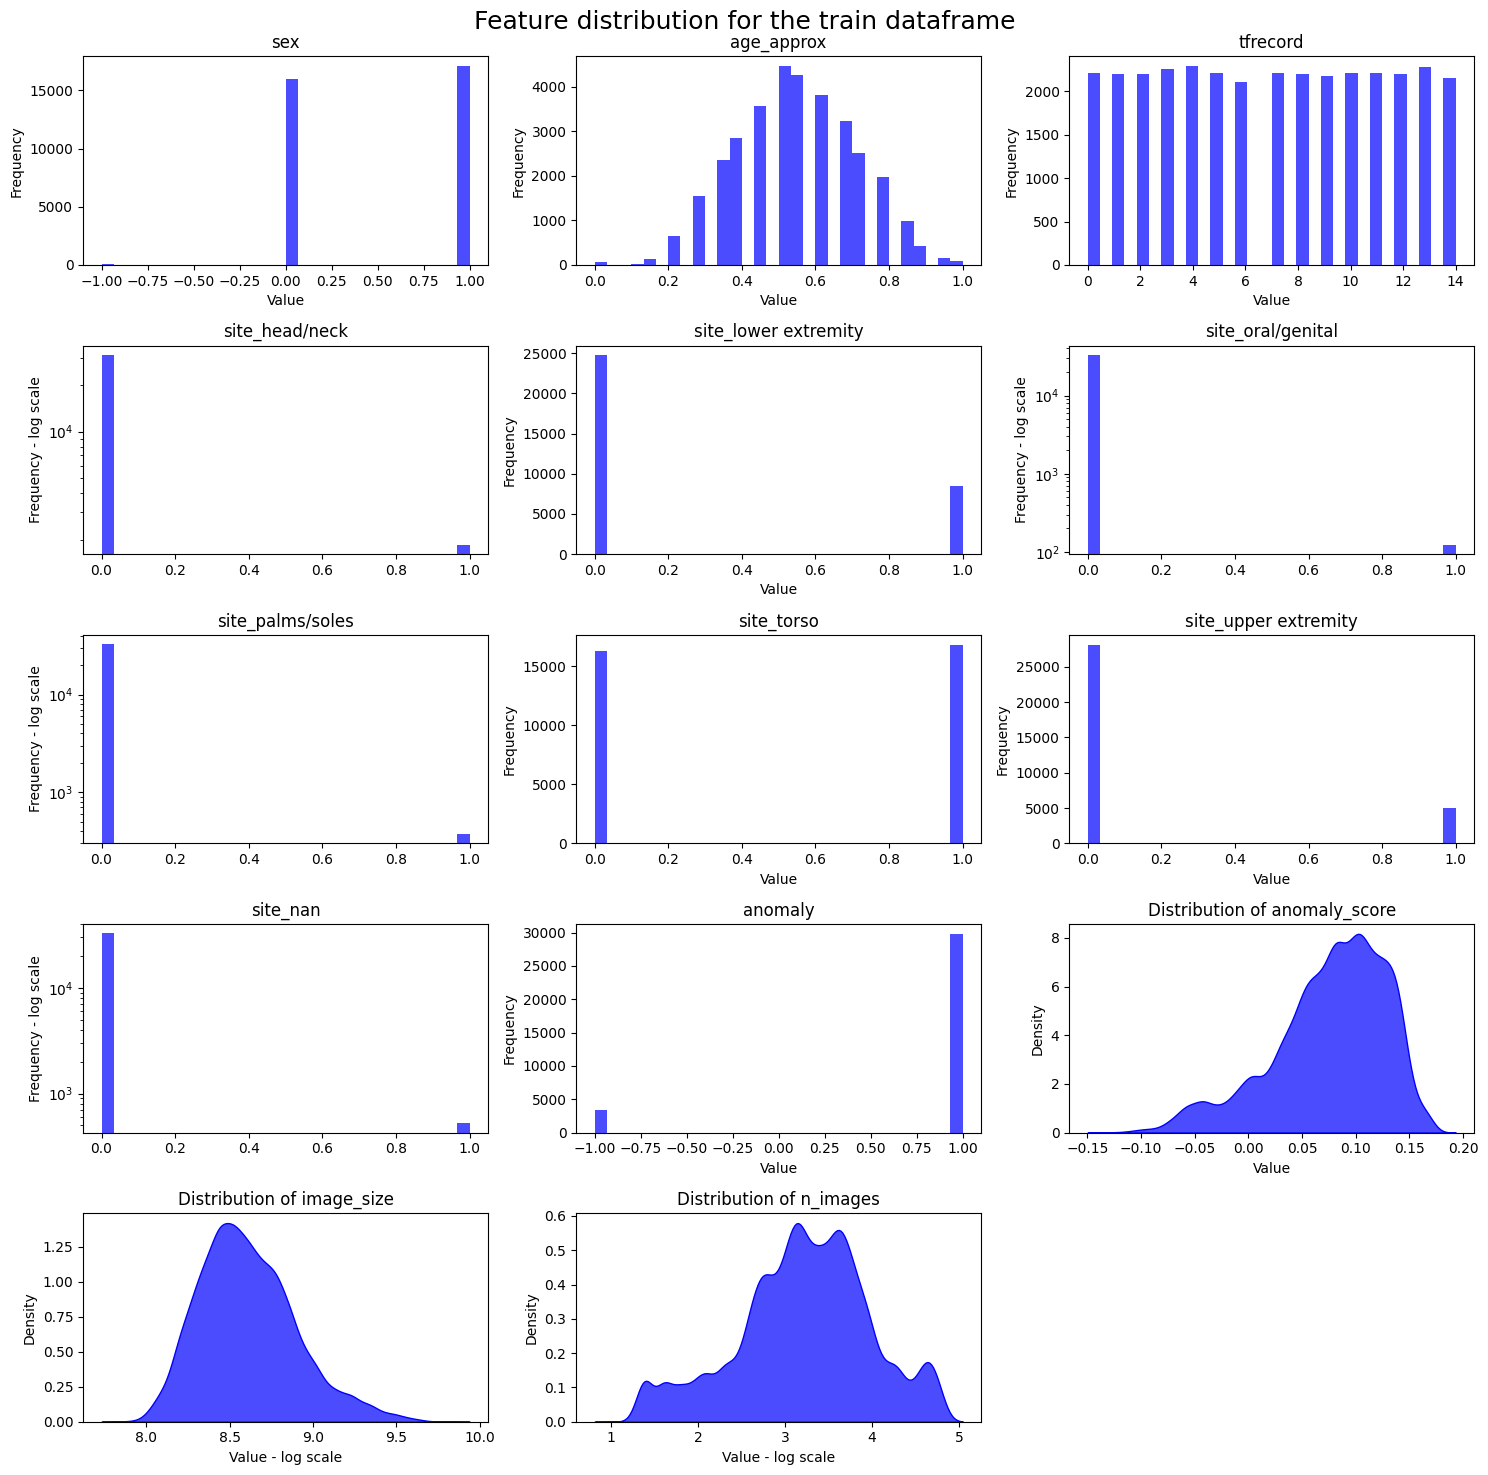

In [4]:
plot_features_distribution(df_train_preprocessed)

## Correlations

In [5]:
def plots_corr_heatmaps(df: pd.DataFrame):
    """ Plots correlation heatmaps for the numeric and categorical features """
    df = df.drop(columns=["is_ext"])
    num_cols = df.select_dtypes(include=['number']).columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    pearson_corr = df[num_cols].corr(method='pearson')
    df_encoded = df[cat_cols].apply(lambda x: x.astype('category').cat.codes if x.nunique() > 1 else x)
    
    # heatmap for the numeric feeatures
    plt.figure(figsize=(10, 6))
    sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Pearson Correlation Matrix (Numerical Features)")
    plt.show()

    # heatmap for the categorical features
    spearman_corr = df_encoded.corr(method='spearman')
    if not spearman_corr.empty:  # Only plot if there are categorical features
        plt.figure(figsize=(10, 6))
        sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Spearman Correlation Matrix (Categorical Features)")
        plt.show()



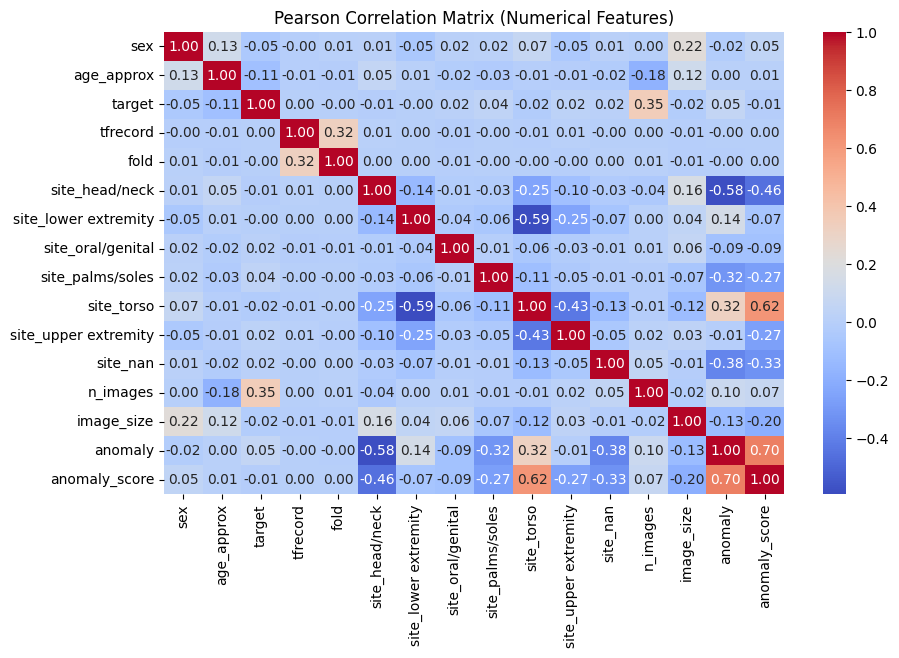

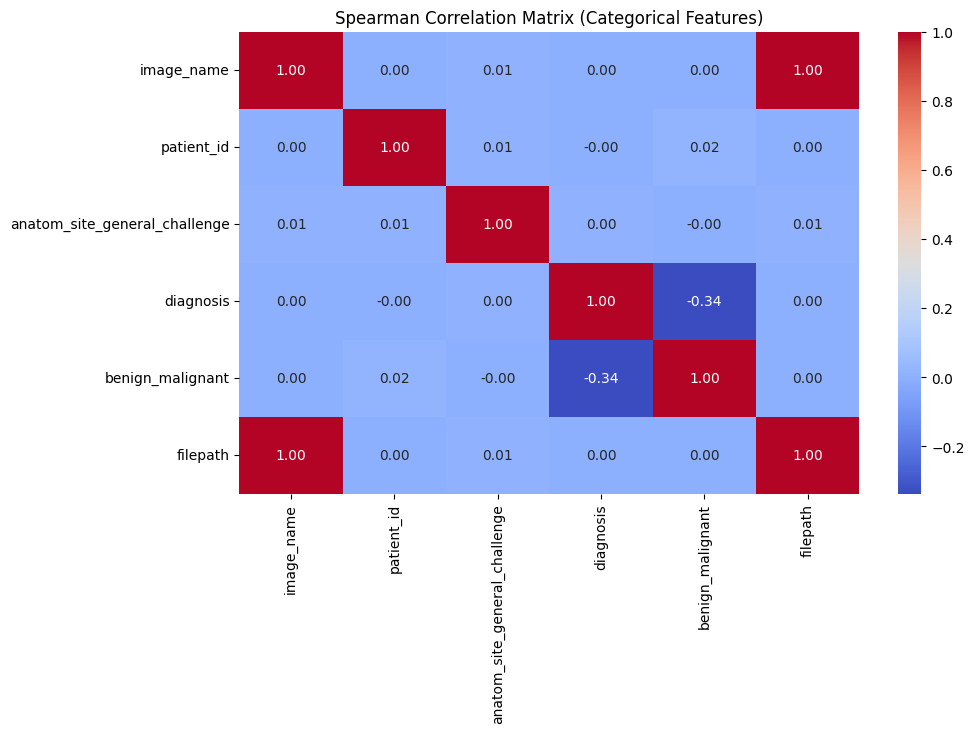

In [6]:
plots_corr_heatmaps(df_train_preprocessed)


 plot diagnosis (target) distribution - before preprocessing

/var/folders/g0/lydy3mw15b509bkm66ls93480000gn/T/ipykernel_48218/3112224420.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diagnosis', data=df_train_unprocessed, order=df_train_unprocessed['diagnosis'].value_counts().index, palette='Set2')


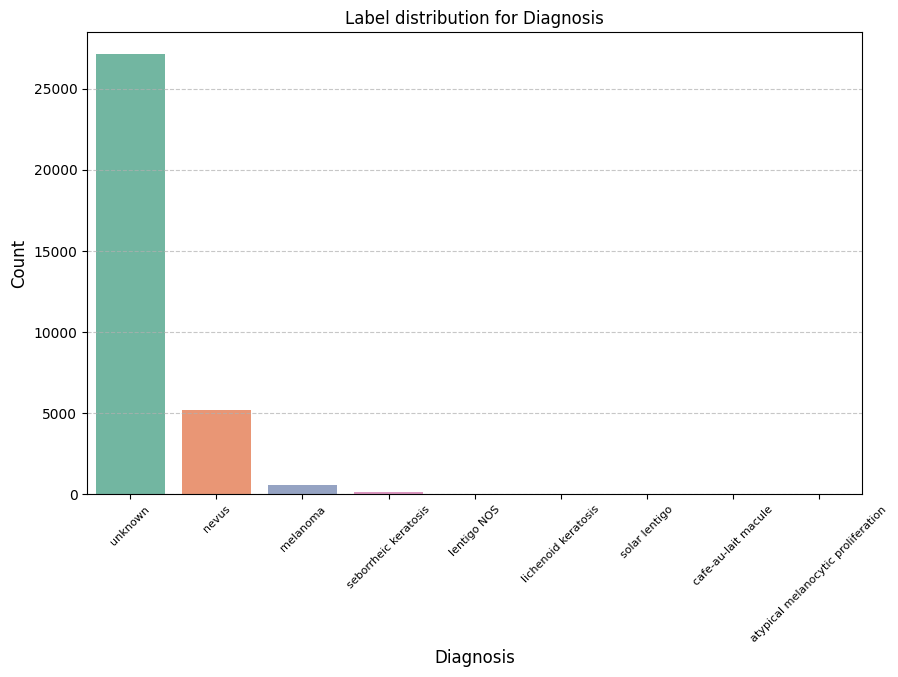

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='diagnosis', data=df_train_unprocessed, order=df_train_unprocessed['diagnosis'].value_counts().index, palette='Set2')
plt.title("Label distribution for Diagnosis")
plt.xlabel("Diagnosis", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()

# Loss of the CNN and the XGBoost models

## Analysis of loss of the CNN model

In [ ]:
cnn_log_file = "log_9c_meta_b3_768_512_ext_18ep.txt" # The log file of the CNN model

In [9]:
def plot_loss(log_file: str):
    if not os.path.exists(log_file):
        raise RuntimeError(f"Expected log file in directory {log_file}")
    with open(log_file, 'r') as file:
        log_content = file.read()
    pattern = r'Fold (\d+), Epoch (\d+), .*?train loss: ([0-9.]+), valid loss: ([0-9.]+)'
    data = re.findall(pattern, log_content)
    df = pd.DataFrame(data, columns=['Fold', 'Epoch', 'Train Loss', 'Valid Loss'])
    df[['Fold', 'Epoch']] = df[['Fold', 'Epoch']].astype(int)
    df[['Train Loss', 'Valid Loss']] = df[['Train Loss', 'Valid Loss']].astype(float)
    fig, ax = plt.subplots(figsize=(10, 5))
    for fold in df['Fold'].unique():
        fold_data = df[df['Fold'] == fold]
        ax.plot(fold_data['Epoch'], fold_data['Train Loss'], label=f'Fold {fold} Train Loss')
        ax.plot(fold_data['Epoch'], fold_data['Valid Loss'], label=f'Fold {fold} Valid Loss', linestyle='--')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss by Fold')
    ax.legend()
    plt.show()


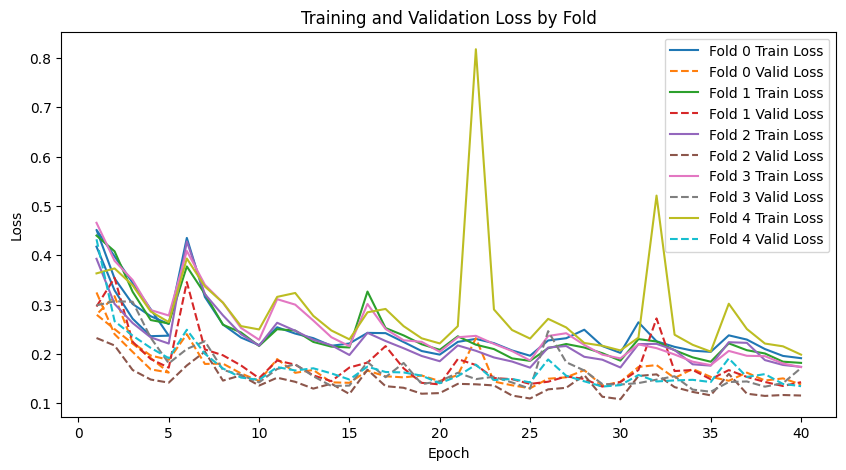

In [10]:
plot_loss(cnn_log_file)

## Loss analysis of the XGBoost model

In [11]:
xgboost_log_data = """[0]	validation_0-mlogloss:1.24316
[1]	validation_0-mlogloss:1.12696
[2]	validation_0-mlogloss:1.03079
[3]	validation_0-mlogloss:0.94905
[4]	validation_0-mlogloss:0.87853
[5]	validation_0-mlogloss:0.81788
[6]	validation_0-mlogloss:0.76499
[7]	validation_0-mlogloss:0.71811
[8]	validation_0-mlogloss:0.67718
[9]	validation_0-mlogloss:0.64101
[10]	validation_0-mlogloss:0.60892
[11]	validation_0-mlogloss:0.57978
[12]	validation_0-mlogloss:0.55400
[13]	validation_0-mlogloss:0.53081
[14]	validation_0-mlogloss:0.51028
[15]	validation_0-mlogloss:0.49171
[16]	validation_0-mlogloss:0.47504
[17]	validation_0-mlogloss:0.45993
[18]	validation_0-mlogloss:0.44642
[19]	validation_0-mlogloss:0.43417
[20]	validation_0-mlogloss:0.42331
[21]	validation_0-mlogloss:0.41322
[22]	validation_0-mlogloss:0.40419
[23]	validation_0-mlogloss:0.39566
[24]	validation_0-mlogloss:0.38819
[25]	validation_0-mlogloss:0.38121
[26]	validation_0-mlogloss:0.37483
[27]	validation_0-mlogloss:0.36879
[28]	validation_0-mlogloss:0.36329
[29]	validation_0-mlogloss:0.35825
[30]	validation_0-mlogloss:0.35371
[31]	validation_0-mlogloss:0.34953
[32]	validation_0-mlogloss:0.34558
[33]	validation_0-mlogloss:0.34214
[34]	validation_0-mlogloss:0.33888
[35]	validation_0-mlogloss:0.33592
[36]	validation_0-mlogloss:0.33317
[37]	validation_0-mlogloss:0.33042
[38]	validation_0-mlogloss:0.32777
[39]	validation_0-mlogloss:0.32534
[40]	validation_0-mlogloss:0.32306
[41]	validation_0-mlogloss:0.32113
[42]	validation_0-mlogloss:0.31954
[43]	validation_0-mlogloss:0.31783
[44]	validation_0-mlogloss:0.31657
[45]	validation_0-mlogloss:0.31518
[46]	validation_0-mlogloss:0.31378
[47]	validation_0-mlogloss:0.31268
[48]	validation_0-mlogloss:0.31131
[49]	validation_0-mlogloss:0.30992
[50]	validation_0-mlogloss:0.30920
[51]	validation_0-mlogloss:0.30800
[52]	validation_0-mlogloss:0.30710
[53]	validation_0-mlogloss:0.30636
[54]	validation_0-mlogloss:0.30544
[55]	validation_0-mlogloss:0.30464
[56]	validation_0-mlogloss:0.30395
[57]	validation_0-mlogloss:0.30300
[58]	validation_0-mlogloss:0.30210
[59]	validation_0-mlogloss:0.30130
[60]	validation_0-mlogloss:0.30070
[61]	validation_0-mlogloss:0.29971
[62]	validation_0-mlogloss:0.29915
[63]	validation_0-mlogloss:0.29868
[64]	validation_0-mlogloss:0.29813
[65]	validation_0-mlogloss:0.29762
[66]	validation_0-mlogloss:0.29719
[67]	validation_0-mlogloss:0.29684
[68]	validation_0-mlogloss:0.29627
[69]	validation_0-mlogloss:0.29588
[70]	validation_0-mlogloss:0.29546
[71]	validation_0-mlogloss:0.29500
[72]	validation_0-mlogloss:0.29484
[73]	validation_0-mlogloss:0.29415
[74]	validation_0-mlogloss:0.29364
[75]	validation_0-mlogloss:0.29318
[76]	validation_0-mlogloss:0.29205
[77]	validation_0-mlogloss:0.29117
[78]	validation_0-mlogloss:0.29017
[79]	validation_0-mlogloss:0.28970
[80]	validation_0-mlogloss:0.28895
[81]	validation_0-mlogloss:0.28860
[82]	validation_0-mlogloss:0.28782
[83]	validation_0-mlogloss:0.28712
[84]	validation_0-mlogloss:0.28672
[85]	validation_0-mlogloss:0.28613
[86]	validation_0-mlogloss:0.28591
[87]	validation_0-mlogloss:0.28555
[88]	validation_0-mlogloss:0.28519
[89]	validation_0-mlogloss:0.28501
[90]	validation_0-mlogloss:0.28470
[91]	validation_0-mlogloss:0.28455
[92]	validation_0-mlogloss:0.28450
[93]	validation_0-mlogloss:0.28341
[94]	validation_0-mlogloss:0.28271
[95]	validation_0-mlogloss:0.28205
[96]	validation_0-mlogloss:0.28086
[97]	validation_0-mlogloss:0.28064
[98]	validation_0-mlogloss:0.28008
[99]	validation_0-mlogloss:0.27948
[100]	validation_0-mlogloss:0.27901
[101]	validation_0-mlogloss:0.27881
[102]	validation_0-mlogloss:0.27834
[103]	validation_0-mlogloss:0.27785
[104]	validation_0-mlogloss:0.27763
[105]	validation_0-mlogloss:0.27725
[106]	validation_0-mlogloss:0.27682
[107]	validation_0-mlogloss:0.27589
[108]	validation_0-mlogloss:0.27557
[109]	validation_0-mlogloss:0.27456
[110]	validation_0-mlogloss:0.27386
[111]	validation_0-mlogloss:0.27348
[112]	validation_0-mlogloss:0.27283
[113]	validation_0-mlogloss:0.27237
[114]	validation_0-mlogloss:0.27209
[115]	validation_0-mlogloss:0.27151
[116]	validation_0-mlogloss:0.27114
[117]	validation_0-mlogloss:0.27064
[118]	validation_0-mlogloss:0.27053
[119]	validation_0-mlogloss:0.27018
[120]	validation_0-mlogloss:0.27016
[121]	validation_0-mlogloss:0.27016
[122]	validation_0-mlogloss:0.26975
[123]	validation_0-mlogloss:0.26976
[124]	validation_0-mlogloss:0.26925
[125]	validation_0-mlogloss:0.26881
[126]	validation_0-mlogloss:0.26811
[127]	validation_0-mlogloss:0.26795
[128]	validation_0-mlogloss:0.26751
[129]	validation_0-mlogloss:0.26728
[130]	validation_0-mlogloss:0.26681
[131]	validation_0-mlogloss:0.26617
[132]	validation_0-mlogloss:0.26583
[133]	validation_0-mlogloss:0.26530
[134]	validation_0-mlogloss:0.26488
[135]	validation_0-mlogloss:0.26417
[136]	validation_0-mlogloss:0.26328
[137]	validation_0-mlogloss:0.26246
[138]	validation_0-mlogloss:0.26198
[139]	validation_0-mlogloss:0.26198
[140]	validation_0-mlogloss:0.26137
[141]	validation_0-mlogloss:0.26101
[142]	validation_0-mlogloss:0.26022
[143]	validation_0-mlogloss:0.26001
[144]	validation_0-mlogloss:0.25995
[145]	validation_0-mlogloss:0.25942
[146]	validation_0-mlogloss:0.25933
[147]	validation_0-mlogloss:0.25927
[148]	validation_0-mlogloss:0.25874
[149]	validation_0-mlogloss:0.25856
[150]	validation_0-mlogloss:0.25816
[151]	validation_0-mlogloss:0.25779
[152]	validation_0-mlogloss:0.25739
[153]	validation_0-mlogloss:0.25725
[154]	validation_0-mlogloss:0.25688
[155]	validation_0-mlogloss:0.25673
[156]	validation_0-mlogloss:0.25620
[157]	validation_0-mlogloss:0.25575
[158]	validation_0-mlogloss:0.25496
[159]	validation_0-mlogloss:0.25437
[160]	validation_0-mlogloss:0.25411
[161]	validation_0-mlogloss:0.25381
[162]	validation_0-mlogloss:0.25352
[163]	validation_0-mlogloss:0.25338
[164]	validation_0-mlogloss:0.25317
[165]	validation_0-mlogloss:0.25300
[166]	validation_0-mlogloss:0.25296
[167]	validation_0-mlogloss:0.25282
[168]	validation_0-mlogloss:0.25279
[169]	validation_0-mlogloss:0.25271
[170]	validation_0-mlogloss:0.25213
[171]	validation_0-mlogloss:0.25212
[172]	validation_0-mlogloss:0.25173
[173]	validation_0-mlogloss:0.25123
[174]	validation_0-mlogloss:0.25111
[175]	validation_0-mlogloss:0.25073
[176]	validation_0-mlogloss:0.24997
[177]	validation_0-mlogloss:0.24947
[178]	validation_0-mlogloss:0.24937
[179]	validation_0-mlogloss:0.24928
[180]	validation_0-mlogloss:0.24889
[181]	validation_0-mlogloss:0.24866
[182]	validation_0-mlogloss:0.24815
[183]	validation_0-mlogloss:0.24805
[184]	validation_0-mlogloss:0.24786
[185]	validation_0-mlogloss:0.24755
[186]	validation_0-mlogloss:0.24714
[187]	validation_0-mlogloss:0.24700
[188]	validation_0-mlogloss:0.24671
[189]	validation_0-mlogloss:0.24652
[190]	validation_0-mlogloss:0.24637
[191]	validation_0-mlogloss:0.24613
[192]	validation_0-mlogloss:0.24597
[193]	validation_0-mlogloss:0.24598
[194]	validation_0-mlogloss:0.24592
[195]	validation_0-mlogloss:0.24557
[196]	validation_0-mlogloss:0.24534
[197]	validation_0-mlogloss:0.24500
[198]	validation_0-mlogloss:0.24458
[199]	validation_0-mlogloss:0.24450
Test Accuracy: 0.9213703591910655
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.44      0.07      0.12       115
           2       0.90      0.66      0.76      1018
           3       0.93      1.00      0.96      5448

    accuracy                           0.92      6626
   macro avg       0.57      0.43      0.46      6626
weighted avg       0.91      0.92      0.91      6626

F-2 score: 0.92"""

In [14]:
def plot_xgboost_loss(content: str, color: str):
    with open("log_data.txt", "w") as file:
        file.write(content)
    with open("log_data.txt", "r") as file:
        log_content = file.read()

    # pattern for loss
    pattern = r'\[(\d+)\]\s+validation_0-mlogloss:([0-9.]+)'
    matches = re.findall(pattern, log_content)
    df = pd.DataFrame(matches, columns=['Iteration', 'Validation Loss'])
    df['Iteration'] = df['Iteration'].astype(int)
    df['Validation Loss'] = df['Validation Loss'].astype(float)

    plt.figure(figsize=(10, 5))
    plt.plot(df['Iteration'], df['Validation Loss'], marker='o', label='Validation Loss', color= color)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid()
    plt.title('Validation Loss per Iteration')
    plt.show()


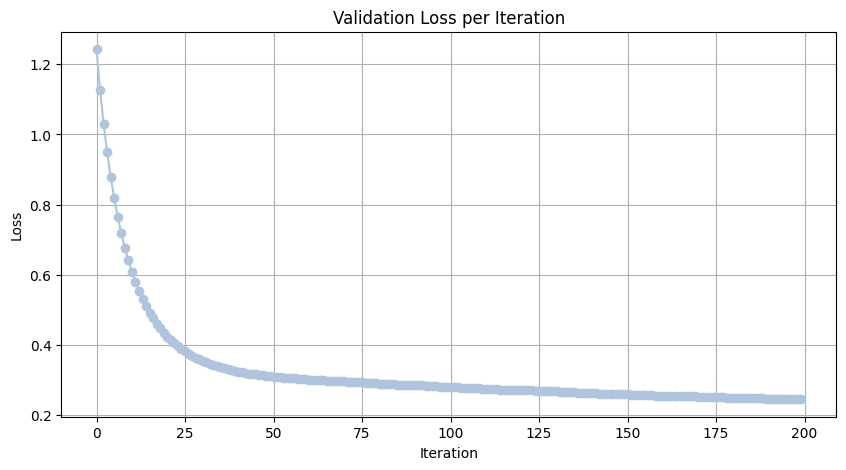

In [15]:
plot_xgboost_loss(xgboost_log_data, color = 'lightsteelblue')

## Plot ROC curve for the combined models

In [ ]:
cross_val_results = "cross_val_oof_predictions_auc.csv"

In [25]:
def plot_roc(cross_val_results_path: str):
    """ Prints the AUC of the train dataset and plots ROC curve"""
    if not os.path.exists(cross_val_results_path):
        raise RuntimeError(f"Expected cross validation results file in directory {cross_val_results_path}")
    df = pd.read_csv(cross_val_results_path)
    df["is_melanoma"] = (df["target"] == 1).astype(int)
    y_true = df["is_melanoma"]
    y_score = df["oof_predictions"]
    auc_score = roc_auc_score(y_true, y_score)
    print(f"Combined model AUC = {auc_score:.4f}")

    plt.figure(figsize=(6, 6))
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, color= 'lightsteelblue', label=f"ROC curve (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--", label="Random Classifier")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(True)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve: Melanoma vs. Not Melanoma")
    plt.legend(loc="lower right")
    plt.show()


Combined model AUC = 0.9469


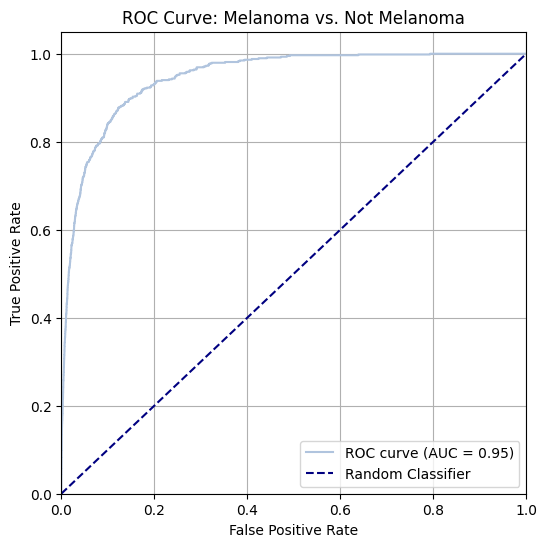

In [26]:
plot_roc(cross_val_results)